In [1]:
import torch
import numpy as np
import os
import timeit
import time

# PyTorch uses 'nn.Module' as the base class for all neural network modules.
class TBHNN(torch.nn.Module):
    """
    Tight-binding Hamiltonian neural network
    """

    def __init__(self):
        super(TBHNN, self).__init__()
        self.H_size_added = 0
        # We will add more attributes and initializations as we convert other methods

    # Placeholder for read_training_set method, will be filled in later
    def read_training_set(self, references, k_vectors):
        num_k, num_b = references.shape
        self.num_b = num_b
        self.num_k = num_k
        self.H_size_init = num_b
        self.H_size = num_b
        self.references = torch.tensor(references, dtype=torch.float32, requires_grad=True)
        self.k_vectors = torch.tensor(k_vectors, dtype=torch.float32, requires_grad=True)
        # In PyTorch, tensors are automatically placed on the default device, so we don't
        # need to explicitly define device placement as in TensorFlow
        pass

    # Placeholder for define_TB_representation method, will be filled in later
    def define_TB_representation(self, vectors_without_opposite):
        # In PyTorch, we usually do not need to cast to complex inside class methods,
        # unless it is necessary for certain operations.
        num_r = len(vectors_without_opposite)
        self.num_r = num_r
        self.R = torch.nn.Parameter(torch.zeros((num_r, 3), dtype=torch.float32))

        # Then you can create a new tensor for R without in-place operations
        new_R_values = []
        for i, vector in enumerate(vectors_without_opposite):
            if not np.all(np.isclose(vector, 0.0)):
                new_R_values.append(torch.tensor(vector, dtype=torch.float32))
            else:
                new_R_values.append(torch.zeros(3, dtype=torch.float32))

        # Now you can concatenate the list of tensors into a single tensor
        new_R = torch.stack(new_R_values)

        # If 'self.R' needs to maintain its gradient, you should replace it with 'new_R' like so:
        self.R = torch.nn.Parameter(new_R)

        self.R_without_opposite = vectors_without_opposite

        pass

    # Placeholder for reinitialize method, will be filled in later
    def reinitialize(self,alpha):
        self.H_R = torch.nn.ParameterList()  # Use ParameterList instead of ModuleList
        self.H_size = self.H_size_init + self.H_size_added

        for _ in self.R_without_opposite:
            H_tmp = torch.nn.Parameter(torch.randn((self.H_size, self.H_size), dtype=torch.float32) * alpha)
            self.H_R.append((2**-0.5)*(H_tmp+H_tmp.t()))
        pass

    # Placeholder for compute_bands method, will be filled in later
    def compute_bands(self):
        reproduced_bands = torch.zeros((self.num_k, self.H_size), dtype=torch.float32)
        
        for i in range(self.num_k):
            K = torch.zeros((self.H_size, self.H_size), dtype=torch.complex64)
            for j, H_R_component in enumerate(self.H_R):
                exp_factor = torch.exp(-1j * np.pi * torch.matmul(self.k_vectors[i], self.R[j]))
                K += exp_factor * H_R_component
                
            # Eigenvalues are computed from the Hermitian part of K to ensure they are real
            eigenvalues, _ = torch.linalg.eigh(K + K.conj().T)
            reproduced_bands[i] = eigenvalues.real

        # Sort the bands and discard those not needed for loss computation
        reproduced_bands = reproduced_bands[:, :self.H_size_init]
        self.bandstructure = reproduced_bands

        return reproduced_bands

In [ ]:
def Caract(L1,L2,L3,L4):
    n=len(L1)
    S=""
    for a in L1:
        S+=str(a)+","
    S=S[:-1]
    S+=";"
    for b in L2:
        S+=str(b)+","
    S=S[:-1]
    S+=";"
    for c in L3:
        S+=str(c)+","
    S=S[:-1]
    S+=";"
    for c in L4:
        S+=str(c)+","
    S=S[:-1]
    return S

def main(file, N_essais):
    t0=time.time()
    rvectors_without_opposite = np.array([[0,0,0],[0,0,1],], dtype=np.int32) # in units of[a, b, c] (a, b, and c are the real-space basis vectors; [l, n, m] means the lattice vector l*a+n*b+m*c)
    # Load training data
    references = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
    k_vectors = np.load("./data/input/InSe Nanoribbon/InSe-kpoints.npy") # in units of 1/2pi*[ak, bk, ck] (ak, bk, and ck are the corresponding k-space basis vectors; [l, n, m] means the k-vector (l/2pi)*ak+(n/2pi)*bk+(m/2pi)*ck)
    
    max_training_steps = 8000
    threshold = 3e-3
    
    # Initialize the model
    tbhnn = TBHNN()
    tbhnn.read_training_set(references, k_vectors)
    tbhnn.define_TB_representation(rvectors_without_opposite)

    f = open(file, "r")
    S=f.read()
    f.close()

    S1=S.split(";")
    S_alpha=S1[0].split(",")
    S_conv=S1[1].split(",")
    S_essais=S1[2].split(",")
    S_steps=S1[3].split(",")
    
    L_alpha=[float(x) for x in S_alpha]
    L_conv=[float(x) for x in S_conv]
    L_essais=[float(x) for x in S_essais]
    L_steps=[float(x) for x in S_steps]

    print(L_alpha, L_conv, L_essais, L_steps)

    
    
    for i in range(len(L_alpha)):
        alpha=L_alpha[i]
        
        for N in range(N_essais[i]):
            tbhnn.__init__()
            tbhnn.read_training_set(references, k_vectors)
            tbhnn.define_TB_representation(rvectors_without_opposite)
            optimizer = torch.optim.Adam(tbhnn.parameters(), lr=0.001)
            tbhnn.reinitialize(alpha)

            
            print(L_conv, L_essais)
            t=time.time()-t0
            print(f"Time: {t} s")
            # Define the optimizer
            optimizer = torch.optim.Adam(tbhnn.parameters(), lr=0.001)
            
            # Training loop
            fini=False
            for step in range(max_training_steps):
                optimizer.zero_grad()
                reproduced_bands = tbhnn.compute_bands()
                loss = torch.nn.SmoothL1Loss()(reproduced_bands,tbhnn.references)
                loss.backward()
                optimizer.step()
        
                if step % 1000 ==0:
                    print(f"Step {step}, Loss: {loss.item()}")
        
                if loss.item() < threshold:
                    print("Convergence reached.")
                    L_conv[i]+=1
                    L_steps[i]+=step
                    fini=1
                    break

                if step==max_training_steps-1:
                    L_steps[i]+=step
                    fini=1
            if fini:
                L_essais[i]+=1
                S=Caract(L_alpha, L_conv, L_essais, L_steps)
                f = open(file, "w")
                f.write(S)
                f.close()






In [ ]:

N_essais=[1 for i in range(16)]
while True:
    main("AmpG_8.txt",N_essais)

[0.05, 0.060000000000000005, 0.07, 0.08000000000000002, 0.09000000000000001, 0.1, 0.11000000000000001, 0.12000000000000001, 0.13, 0.14, 0.15000000000000002, 0.16000000000000003, 0.17000000000000004, 0.18000000000000005, 0.19, 0.2] [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0] [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0] [15998.0, 15998.0, 15998.0, 15998.0, 15998.0, 3782.0, 15998.0, 10953.0, 15998.0, 10656.0, 9976.0, 10431.0, 15998.0, 15998.0, 11382.0, 10908.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0] [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Time: 1.531820297241211 s
Step 0, Loss: 0.6834121346473694
Step 1000, Loss: 0.004636428784579039
Step 2000, Loss: 0.004480418749153614
Step 3000, Loss: 0.004471977241337299
Step 4000, Loss: 0.004470200277864933
Step 5000, Loss: 0.004469572100788355
Step 6000, Loss: 0.004469237290322781
Step 7000, Loss

Step 1000, Loss: 0.004651573020964861
Step 2000, Loss: 0.004480883479118347
Step 3000, Loss: 0.004472393076866865
Step 4000, Loss: 0.004470684565603733
Step 5000, Loss: 0.004469967447221279
Step 6000, Loss: 0.004469346720725298
Step 7000, Loss: 0.004469133913516998
[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0] [4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
Time: 109.11474895477295 s
Step 0, Loss: 0.6828458309173584
Step 1000, Loss: 0.004713956732302904
Step 2000, Loss: 0.004478218965232372
Step 3000, Loss: 0.004471594002097845
Step 4000, Loss: 0.004470172803848982
Step 5000, Loss: 0.004469638224691153
Step 6000, Loss: 0.004469275940209627
Step 7000, Loss: 0.004469124600291252
[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0] [4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
Time: 218.2777178287506 s
Step 0, Loss: 0.6593411564826965
Step 1000, Loss: 0.004724

Step 1000, Loss: 0.004564965609461069
Step 2000, Loss: 0.004476927220821381
Step 3000, Loss: 0.0044710650108754635
Step 4000, Loss: 0.004469867330044508
Step 5000, Loss: 0.004469409119337797
Step 6000, Loss: 0.004469192586839199
Step 7000, Loss: 0.00446911109611392
[0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0] [5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
Time: 329.19344425201416 s
Step 0, Loss: 0.5708630084991455
Step 1000, Loss: 0.004634130746126175
Step 2000, Loss: 0.004474564455449581
Step 3000, Loss: 0.004470571409910917
Step 4000, Loss: 0.004469540901482105
Step 5000, Loss: 0.00446920283138752
Step 6000, Loss: 0.004469121806323528
Step 7000, Loss: 0.004469106439501047
[0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0] [5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
Time: 438.4327437877655 s
Step 0, Loss: 0.649563729763031
Step 1000, Loss: 0.00479531

Step 5000, Loss: 0.004469710402190685
Step 6000, Loss: 0.004469248000532389
Step 7000, Loss: 0.004469121340662241
[0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 3.0, 0.0, 2.0, 3.0, 2.0, 1.0, 2.0, 2.0, 2.0] [6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Time: 438.22744512557983 s
Step 0, Loss: 0.6282158493995667
Step 1000, Loss: 0.004800685215741396
Step 2000, Loss: 0.004473498556762934
Step 3000, Loss: 0.004470507614314556
Step 4000, Loss: 0.004469684325158596
Step 5000, Loss: 0.0044692340306937695
Step 6000, Loss: 0.00446911808103323
Step 7000, Loss: 0.004469101782888174
[0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 3.0, 0.0, 2.0, 3.0, 2.0, 1.0, 2.0, 2.0, 2.0] [6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Time: 547.6551587581635 s
Step 0, Loss: 0.3918510973453522
Step 1000, Loss: 0.0045195152051746845
Step 2000, Loss: 0.004475733730942011
Step 3000, Loss: 0.004471034277230501
Step 4000, Loss: 0.004469894338399172
Step 5000, Loss: 0.00446

Step 6000, Loss: 0.00446923216804862
Step 7000, Loss: 0.0044691357761621475
[0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 2.0, 3.0, 3.0] [7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
Time: 547.4899060726166 s
Step 0, Loss: 0.46999800205230713
Step 1000, Loss: 0.0045308079570531845
Step 2000, Loss: 0.004475435242056847
Step 3000, Loss: 0.004470984451472759
Step 4000, Loss: 0.004469963721930981
Step 5000, Loss: 0.004469485953450203
Step 6000, Loss: 0.004469189327210188
Step 7000, Loss: 0.004469107370823622
[0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 2.0, 3.0, 3.0] [7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
Time: 657.2907514572144 s
Step 0, Loss: 0.542747974395752
Step 1000, Loss: 0.0045833406038582325
Step 2000, Loss: 0.0044731213711202145
Step 3000, Loss: 0.00447077676653862
Step 4000, Loss: 0.0044700829312205315
Step 5000, Loss: 0.004469526465982199
Step 6000, Loss: 0.0044

Step 2000, Loss: 0.004473111592233181
Step 3000, Loss: 0.00447078375145793
Step 4000, Loss: 0.004469985608011484
Step 5000, Loss: 0.0044694337993860245
Step 6000, Loss: 0.0044691418297588825
Step 7000, Loss: 0.004469102714210749
[0.0, 0.0, 0.0, 1.0, 1.0, 5.0, 2.0, 4.0, 1.0, 4.0, 3.0, 3.0, 2.0, 2.0, 3.0, 4.0] [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
Time: 644.6948738098145 s
Step 0, Loss: 0.5210692286491394
Step 1000, Loss: 0.004572106059640646
Step 2000, Loss: 0.004476821515709162
Step 3000, Loss: 0.004471351392567158
Step 4000, Loss: 0.004470193292945623
Step 5000, Loss: 0.004469663370400667
Step 6000, Loss: 0.004469273611903191
Step 7000, Loss: 0.004469125531613827
[0.0, 0.0, 0.0, 1.0, 1.0, 5.0, 2.0, 4.0, 1.0, 4.0, 3.0, 3.0, 2.0, 2.0, 3.0, 4.0] [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
Time: 754.2123074531555 s
Step 0, Loss: 0.8138644099235535
Step 1000, Loss: 0.006430725567042828
Step 2000, Loss: 0.004475

Step 1000, Loss: 0.004214955028146505
Step 2000, Loss: 0.00397779606282711
Convergence reached.
[0.0, 0.0, 0.0, 1.0, 2.0, 6.0, 3.0, 4.0, 2.0, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0] [9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
Time: 696.6602449417114 s
Step 0, Loss: 0.6203187108039856
Step 1000, Loss: 0.004712362308055162
Step 2000, Loss: 0.004481526557356119
Step 3000, Loss: 0.004472464323043823
Step 4000, Loss: 0.004470568150281906
Step 5000, Loss: 0.004469987004995346
Step 6000, Loss: 0.004469569772481918
Step 7000, Loss: 0.004469179082661867
[0.0, 0.0, 0.0, 1.0, 2.0, 6.0, 3.0, 4.0, 2.0, 5.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0] [9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0]
Time: 806.0293924808502 s
Step 0, Loss: 0.8381714224815369
Step 1000, Loss: 0.0070796688087284565
Step 2000, Loss: 0.0044747027568519115
Step 3000, Loss: 0.00447069201618433
Step 4000, Loss: 0.004469756036996841
Step 5000, Loss: 0.004469345789402723
Step 

Step 1000, Loss: 0.00479527935385704
Step 2000, Loss: 0.004073352087289095
Step 3000, Loss: 0.0030084727331995964
Convergence reached.
[0.0, 0.0, 1.0, 2.0, 2.0, 6.0, 4.0, 4.0, 2.0, 5.0, 4.0, 4.0, 4.0, 4.0, 3.0, 5.0] [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0]
Time: 954.8788883686066 s
Step 0, Loss: 0.7329085469245911
Step 1000, Loss: 0.004792572930455208
Step 2000, Loss: 0.00448895338922739
Step 3000, Loss: 0.004475148394703865
Step 4000, Loss: 0.004471543710678816
Step 5000, Loss: 0.004470435902476311
Step 6000, Loss: 0.0044698575511574745
Step 7000, Loss: 0.004469340201467276
[0.0, 0.0, 1.0, 2.0, 2.0, 6.0, 4.0, 4.0, 2.0, 5.0, 4.0, 4.0, 4.0, 4.0, 3.0, 5.0] [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0]
Time: 1064.3797311782837 s
Step 0, Loss: 0.6812261939048767
Step 1000, Loss: 0.004364395048469305
Step 2000, Loss: 0.004076091572642326
Step 3000, Loss: 0.0039556329138576984
Convergence re

Step 3000, Loss: 0.003987590316683054
Convergence reached.
[0.0, 0.0, 1.0, 2.0, 2.0, 6.0, 4.0, 4.0, 2.0, 6.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0] [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 10.0, 10.0, 10.0]
Time: 1283.388985157013 s
Step 0, Loss: 0.5889001488685608
Step 1000, Loss: 0.004241396207362413
Step 2000, Loss: 0.004056617151945829
Convergence reached.
[0.0, 0.0, 1.0, 2.0, 2.0, 6.0, 4.0, 4.0, 2.0, 6.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0] [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 10.0, 10.0]
Time: 1320.5987734794617 s
Step 0, Loss: 0.6204452514648438
Step 1000, Loss: 0.004345291294157505
Step 2000, Loss: 0.0040816981345415115
Convergence reached.
[0.0, 0.0, 1.0, 2.0, 2.0, 6.0, 4.0, 4.0, 2.0, 6.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0] [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 10.0]
Time: 1361.6400423049927 s
Step 0, Loss: 0.6260468363761902
Step 1000, Loss: 0.00455474806949

Step 6000, Loss: 0.004469207488000393
Step 7000, Loss: 0.004469115752726793
[0.0, 0.0, 1.0, 3.0, 3.0, 6.0, 4.0, 4.0, 2.0, 7.0, 4.0, 5.0, 6.0, 5.0, 5.0, 6.0] [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0]
Time: 1257.9668622016907 s
Step 0, Loss: 0.6256884932518005
Step 1000, Loss: 0.004350143019109964
Step 2000, Loss: 0.0040772235952317715
Step 3000, Loss: 0.0037127542309463024
Convergence reached.
[0.05, 0.060000000000000005, 0.07, 0.08000000000000002, 0.09000000000000001, 0.1, 0.11000000000000001, 0.12000000000000001, 0.13, 0.14, 0.15000000000000002, 0.16000000000000003, 0.17000000000000004, 0.18000000000000005, 0.19, 0.2] [0.0, 0.0, 1.0, 3.0, 3.0, 6.0, 4.0, 4.0, 2.0, 7.0, 4.0, 5.0, 6.0, 5.0, 5.0, 7.0] [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0] [95988.0, 95988.0, 89690.0, 78249.0, 78158.0, 60149.0, 73637.0, 73507.0, 84155.0, 56827.0, 72405.0, 68921.0, 65248.0, 69476.0, 71470.0, 6046

Step 1000, Loss: 0.004702925216406584
Step 2000, Loss: 0.0044799200259149075
Step 3000, Loss: 0.004472171887755394
Step 4000, Loss: 0.0044704824686050415
Step 5000, Loss: 0.004469803534448147
Step 6000, Loss: 0.004469351377338171
Step 7000, Loss: 0.0044691432267427444
[0.0, 0.0, 1.0, 3.0, 3.0, 6.0, 4.0, 5.0, 3.0, 7.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0] [14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
Time: 109.62252044677734 s
Step 0, Loss: 0.641730546951294
Step 1000, Loss: 0.004615847021341324
Step 2000, Loss: 0.0044793845154345036
Step 3000, Loss: 0.004471757914870977
Step 4000, Loss: 0.004470193292945623
Step 5000, Loss: 0.0044695716351270676
Step 6000, Loss: 0.004469224251806736
Step 7000, Loss: 0.0044691357761621475
[0.0, 0.0, 1.0, 3.0, 3.0, 6.0, 4.0, 5.0, 3.0, 7.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0] [14.0, 14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
Time: 219.49886441230774 s
Step 0, Loss: 0.6119

[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 4.0, 8.0, 5.0, 6.0, 6.0, 6.0, 6.0, 8.0] [15.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
Time: 109.63392806053162 s
Step 0, Loss: 0.644488513469696
Step 1000, Loss: 0.0046358974650502205
Step 2000, Loss: 0.004480083007365465
Step 3000, Loss: 0.004471970722079277
Step 4000, Loss: 0.0044701737351715565
Step 5000, Loss: 0.004469570703804493
Step 6000, Loss: 0.004469227511435747
Step 7000, Loss: 0.004469120409339666
[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 4.0, 8.0, 5.0, 6.0, 6.0, 6.0, 6.0, 8.0] [15.0, 15.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
Time: 219.41607356071472 s
Step 0, Loss: 0.6286163926124573
Step 1000, Loss: 0.004654737189412117
Step 2000, Loss: 0.0044769407249987125
Step 3000, Loss: 0.004471313674002886
Step 4000, Loss: 0.004470116924494505
Step 5000, Loss: 0.004469689447432756
Step 6000, Loss: 0.004469320178031921
Step 7000, Loss: 0.004469122

Step 1000, Loss: 0.004621328320354223
Step 2000, Loss: 0.004481781739741564
Step 3000, Loss: 0.004472474567592144
Step 4000, Loss: 0.004470540210604668
Step 5000, Loss: 0.004469842184334993
Step 6000, Loss: 0.004469354171305895
Step 7000, Loss: 0.004469145555049181
[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 4.0, 9.0, 6.0, 6.0, 6.0, 6.0, 7.0, 9.0] [16.0, 16.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
Time: 219.35971331596375 s
Step 0, Loss: 0.5776678323745728
Step 1000, Loss: 0.004562437068670988
Step 2000, Loss: 0.004478145390748978
Step 3000, Loss: 0.0044717504642903805
Step 4000, Loss: 0.004470371175557375
Step 5000, Loss: 0.004469826817512512
Step 6000, Loss: 0.0044694934040308
Step 7000, Loss: 0.0044691781513392925
[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 4.0, 9.0, 6.0, 6.0, 6.0, 6.0, 7.0, 9.0] [16.0, 16.0, 16.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
Time: 328.92436814308167 s
Step 0, Loss: 0.555539309

[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 4.0, 9.0, 7.0, 7.0, 7.0, 6.0, 8.0, 9.0] [17.0, 17.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
Time: 219.79571962356567 s
Step 0, Loss: 0.6360346674919128
Step 1000, Loss: 0.004667528904974461
Step 2000, Loss: 0.004476645495742559
Step 3000, Loss: 0.0044708773493766785
Step 4000, Loss: 0.0044697364792227745
Step 5000, Loss: 0.00446942076086998
Step 6000, Loss: 0.0044692805968225
Step 7000, Loss: 0.004469128791242838
[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 4.0, 9.0, 7.0, 7.0, 7.0, 6.0, 8.0, 9.0] [17.0, 17.0, 17.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
Time: 329.24358654022217 s
Step 0, Loss: 0.5720420479774475
Step 1000, Loss: 0.004575774073600769
Step 2000, Loss: 0.004477570299059153
Step 3000, Loss: 0.004471320193260908
Step 4000, Loss: 0.004470018204301596
Step 5000, Loss: 0.004469580482691526
Step 6000, Loss: 0.004469269420951605
Step 7000, Loss: 0.004469119478

Step 6000, Loss: 0.00446936534717679
Step 7000, Loss: 0.004469245206564665
[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 5.0, 9.0, 7.0, 8.0, 8.0, 7.0, 8.0, 10.0] [18.0, 18.0, 18.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
Time: 328.8213109970093 s
Step 0, Loss: 0.5911365747451782
Step 1000, Loss: 0.004607111681252718
Step 2000, Loss: 0.004475174937397242
Step 3000, Loss: 0.004470933228731155
Step 4000, Loss: 0.004469950683414936
Step 5000, Loss: 0.004469472449272871
Step 6000, Loss: 0.00446920795366168
Step 7000, Loss: 0.004469113890081644
[0.0, 0.0, 1.0, 3.0, 3.0, 7.0, 4.0, 5.0, 5.0, 9.0, 7.0, 8.0, 8.0, 7.0, 8.0, 10.0] [18.0, 18.0, 18.0, 18.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
Time: 438.4170756340027 s
Step 0, Loss: 0.5101999044418335
Step 1000, Loss: 0.0041219997219741344
Convergence reached.
[0.0, 0.0, 1.0, 3.0, 4.0, 7.0, 4.0, 5.0, 5.0, 9.0, 7.0, 8.0, 8.0, 7.0, 8.0, 10.0] [18.0, 18.0, 18.0, 18.0, 18.0, 17.0, 17.0,

Step 1000, Loss: 0.004621122032403946
Step 2000, Loss: 0.004474911838769913
Step 3000, Loss: 0.004470534157007933
Step 4000, Loss: 0.004469640552997589
Step 5000, Loss: 0.0044692885130643845
Step 6000, Loss: 0.004469142761081457
Step 7000, Loss: 0.00446910597383976
[0.0, 0.0, 1.0, 3.0, 4.0, 7.0, 4.0, 6.0, 5.0, 9.0, 7.0, 9.0, 8.0, 7.0, 9.0, 10.0] [19.0, 19.0, 19.0, 19.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
Time: 438.2914481163025 s
Step 0, Loss: 0.6024450659751892
Step 1000, Loss: 0.0046525984071195126
Step 2000, Loss: 0.0044785719364881516
Step 3000, Loss: 0.004471799824386835
Step 4000, Loss: 0.004470277577638626
Step 5000, Loss: 0.004469738807529211
Step 6000, Loss: 0.004469441715627909
Step 7000, Loss: 0.004469186998903751
[0.0, 0.0, 1.0, 3.0, 4.0, 7.0, 4.0, 6.0, 5.0, 9.0, 7.0, 9.0, 8.0, 7.0, 9.0, 10.0] [19.0, 19.0, 19.0, 19.0, 19.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
Time: 547.897762298584 s
Step 0, Loss: 0.60444420

Step 1000, Loss: 0.004638134967535734
Step 2000, Loss: 0.004475146997720003
Step 3000, Loss: 0.004470567684620619
Step 4000, Loss: 0.004469555802643299
Step 5000, Loss: 0.004469247069209814
Step 6000, Loss: 0.004469131585210562
Step 7000, Loss: 0.00446910597383976
[0.0, 0.0, 1.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 9.0, 7.0, 9.0, 8.0, 7.0, 10.0, 11.0] [20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]
Time: 547.3072736263275 s
Step 0, Loss: 0.6935933828353882
Step 1000, Loss: 0.0053375293500721455
Step 2000, Loss: 0.004472561180591583
Step 3000, Loss: 0.0044705369509756565
Step 4000, Loss: 0.004469919949769974
Step 5000, Loss: 0.004469376057386398
Step 6000, Loss: 0.004469129256904125
Step 7000, Loss: 0.004469103179872036
[0.0, 0.0, 1.0, 3.0, 4.0, 7.0, 4.0, 7.0, 6.0, 9.0, 7.0, 9.0, 8.0, 7.0, 10.0, 11.0] [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]
Time: 656.8404922485352 s
Step 0, Loss: 0.560004

Step 2000, Loss: 0.004475753288716078
Step 3000, Loss: 0.0044711316004395485
Step 4000, Loss: 0.004469864536076784
Step 5000, Loss: 0.004469413310289383
Step 6000, Loss: 0.004469163715839386
Step 7000, Loss: 0.004469107370823622
[0.0, 0.0, 1.0, 3.0, 5.0, 7.0, 4.0, 7.0, 7.0, 9.0, 8.0, 10.0, 9.0, 7.0, 10.0, 12.0] [21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
Time: 577.9127464294434 s
Step 0, Loss: 0.4934481978416443
Step 1000, Loss: 0.004544487688690424
Step 2000, Loss: 0.004473960492759943
Step 3000, Loss: 0.004470423795282841
Step 4000, Loss: 0.004469603765755892
Step 5000, Loss: 0.004469271749258041
Step 6000, Loss: 0.004469131585210562
Step 7000, Loss: 0.004469105042517185
[0.0, 0.0, 1.0, 3.0, 5.0, 7.0, 4.0, 7.0, 7.0, 9.0, 8.0, 10.0, 9.0, 7.0, 10.0, 12.0] [21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
Time: 687.5033414363861 s
Step 0, Loss: 0.5015086531639099
Step 1000, Loss: 0.004534

[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 4.0, 7.0, 7.0, 9.0, 8.0, 10.0, 10.0, 7.0, 11.0, 13.0] [22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
Time: 574.3292655944824 s
Step 0, Loss: 0.5557682514190674
Step 1000, Loss: 0.004210876766592264
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 5.0, 7.0, 7.0, 9.0, 8.0, 10.0, 10.0, 7.0, 11.0, 13.0] [22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
Time: 599.783004283905 s
Step 0, Loss: 0.4643687605857849
Step 1000, Loss: 0.004516726825386286
Step 2000, Loss: 0.004473566077649593
Step 3000, Loss: 0.00447029247879982
Step 4000, Loss: 0.004469575826078653
Step 5000, Loss: 0.004469279199838638
Step 6000, Loss: 0.004469156265258789
Step 7000, Loss: 0.004469105042517185
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 5.0, 7.0, 7.0, 9.0, 8.0, 10.0, 10.0, 7.0, 11.0, 13.0] [22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
Time: 709.282

Step 1000, Loss: 0.004651074297726154
Step 2000, Loss: 0.0044743833132088184
Step 3000, Loss: 0.004470544867217541
Step 4000, Loss: 0.004469585604965687
Step 5000, Loss: 0.004469222854822874
Step 6000, Loss: 0.004469120409339666
Step 7000, Loss: 0.004469108302146196
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 7.0, 9.0, 9.0, 11.0, 10.0, 8.0, 12.0, 14.0] [23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
Time: 790.7858748435974 s
Step 0, Loss: 0.4567539393901825
Step 1000, Loss: 0.004100211896002293
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 8.0, 9.0, 9.0, 11.0, 10.0, 8.0, 12.0, 14.0] [23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
Time: 816.8407549858093 s
Step 0, Loss: 0.5485363006591797
Step 1000, Loss: 0.004659452475607395
Step 2000, Loss: 0.004476042930036783
Step 3000, Loss: 0.004471191670745611
Step 4000, Loss: 0.004470152780413628
Step 5000, Loss: 0.004469664767384529
St

Step 6000, Loss: 0.004469342064112425
Step 7000, Loss: 0.004469128325581551
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 10.0, 8.0, 13.0, 14.0] [24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0]
Time: 876.1179304122925 s
Step 0, Loss: 0.4799751043319702
Step 1000, Loss: 0.0045517487451434135
Step 2000, Loss: 0.004478343762457371
Step 3000, Loss: 0.004471530672162771
Step 4000, Loss: 0.004470121581107378
Step 5000, Loss: 0.004469565115869045
Step 6000, Loss: 0.0044691977091133595
Step 7000, Loss: 0.004469109233468771
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 10.0, 8.0, 13.0, 14.0] [24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0]
Time: 985.5045936107635 s
Step 0, Loss: 0.595421552658081
Step 1000, Loss: 0.004374954849481583
Step 2000, Loss: 0.0037464755587279797
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 8.0, 10.0, 10.0, 12.0, 10.0, 8.0, 

Step 1000, Loss: 0.0041629839688539505
Step 2000, Loss: 0.003930635284632444
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 9.0, 10.0, 10.0, 13.0, 11.0, 8.0, 14.0, 15.0] [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
Time: 906.8559000492096 s
Step 0, Loss: 0.5479373931884766
Step 1000, Loss: 0.004249208141118288
Step 2000, Loss: 0.0036019482649862766
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 9.0, 11.0, 10.0, 13.0, 11.0, 8.0, 14.0, 15.0] [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
Time: 934.8697109222412 s
Step 0, Loss: 0.6713034510612488
Step 1000, Loss: 0.004433997441083193
Step 2000, Loss: 0.004043160937726498
Step 3000, Loss: 0.003905152902007103
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 5.0, 7.0, 6.0, 7.0, 9.0, 11.0, 11.0, 13.0, 11.0, 8.0, 14.0, 15.0] [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 24.0, 24.0, 24.0, 24.0, 24.0]

Step 2000, Loss: 0.004011672455817461
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 6.0, 8.0, 7.0, 7.0, 10.0, 11.0, 12.0, 14.0, 11.0, 8.0, 15.0, 15.0] [26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 25.0, 25.0, 25.0, 25.0]
Time: 808.0385057926178 s
Step 0, Loss: 0.5312460064888
Step 1000, Loss: 0.0041795168071985245
Step 2000, Loss: 0.003972368780523539
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 6.0, 8.0, 7.0, 7.0, 10.0, 11.0, 12.0, 15.0, 11.0, 8.0, 15.0, 15.0] [26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 25.0, 25.0, 25.0, 25.0]
Time: 838.0771095752716 s
Step 0, Loss: 0.6419498920440674
Step 1000, Loss: 0.0046872724778950214
Step 2000, Loss: 0.004494361113756895
Step 3000, Loss: 0.00447557307779789
Step 4000, Loss: 0.004471287131309509
Step 5000, Loss: 0.004470050800591707
Step 6000, Loss: 0.00446951063349843
Step 7000, Loss: 0.0044692400842905045
[0.0, 0.0, 1.0, 4.0, 6.0, 8.0, 7.0, 7.0, 10.0, 11.0, 12.0, 15.0, 11.0, 8.0, 15.0, 15.0] [26.

Step 1000, Loss: 0.0041484590619802475
Step 2000, Loss: 0.004018908366560936
Convergence reached.
[0.0, 0.0, 1.0, 4.0, 6.0, 8.0, 8.0, 7.0, 10.0, 11.0, 13.0, 15.0, 11.0, 8.0, 15.0, 15.0] [27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0]
Time: 1047.9766573905945 s
Step 0, Loss: 0.6654800772666931
Step 1000, Loss: 0.004670220427215099
Step 2000, Loss: 0.004476336296647787
Step 3000, Loss: 0.00447121961042285
Step 4000, Loss: 0.004469879902899265
Step 5000, Loss: 0.004469340201467276
Step 6000, Loss: 0.0044691539369523525
Step 7000, Loss: 0.004469107370823622
[0.0, 0.0, 1.0, 4.0, 6.0, 8.0, 8.0, 7.0, 10.0, 11.0, 13.0, 15.0, 11.0, 8.0, 15.0, 15.0] [27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0]
Time: 1157.7039391994476 s
Step 0, Loss: 0.5109430551528931
Step 1000, Loss: 0.004735467955470085
Step 2000, Loss: 0.0045073567889630795
Step 3000, Loss: 0.004479161463677883
Step 4000, Loss: 0.004472089465

Step 1000, Loss: 0.004634072072803974
Step 2000, Loss: 0.004478055518120527
Step 3000, Loss: 0.00447153951972723
Step 4000, Loss: 0.004469978157430887
Step 5000, Loss: 0.004469441249966621
Step 6000, Loss: 0.004469203297048807
Step 7000, Loss: 0.004469125997275114
[0.0, 0.0, 2.0, 4.0, 6.0, 8.0, 8.0, 8.0, 11.0, 11.0, 14.0, 15.0, 11.0, 9.0, 15.0, 15.0] [28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 27.0, 27.0, 27.0, 27.0]
Time: 1002.8521134853363 s
Step 0, Loss: 0.6226579546928406
Step 1000, Loss: 0.004292099270969629
Step 2000, Loss: 0.0040674214251339436
Step 3000, Loss: 0.003988948650658131
Convergence reached.
[0.0, 0.0, 2.0, 4.0, 6.0, 8.0, 8.0, 8.0, 11.0, 11.0, 14.0, 15.0, 12.0, 9.0, 15.0, 15.0] [28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 27.0, 27.0, 27.0]
Time: 1049.8184962272644 s
Step 0, Loss: 0.8993769288063049
Step 1000, Loss: 0.0057234507985413074
Step 2000, Loss: 0.0044831568375229836
Step 3000, Loss: 0.004472936503

Step 1000, Loss: 0.004995635244995356
Step 2000, Loss: 0.004483779892325401
Step 3000, Loss: 0.00447322940453887
Step 4000, Loss: 0.004470827057957649
Step 5000, Loss: 0.004470021463930607
Step 6000, Loss: 0.004469526465982199
Step 7000, Loss: 0.004469210747629404
[0.0, 0.0, 2.0, 4.0, 6.0, 8.0, 8.0, 8.0, 12.0, 11.0, 14.0, 16.0, 12.0, 9.0, 16.0, 16.0] [29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 28.0, 28.0, 28.0]
Time: 1280.2750055789948 s
Step 0, Loss: 0.6576478481292725
Step 1000, Loss: 0.004288852214813232
Step 2000, Loss: 0.0040210699662566185
Convergence reached.
[0.0, 0.0, 2.0, 4.0, 6.0, 8.0, 8.0, 8.0, 12.0, 11.0, 14.0, 16.0, 12.0, 10.0, 16.0, 16.0] [29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 28.0, 28.0]
Time: 1311.62118268013 s
Step 0, Loss: 0.8425402641296387
Step 1000, Loss: 0.005708598997443914
Step 2000, Loss: 0.004501060117036104
Step 3000, Loss: 0.004476691596210003
Step 4000, Loss: 0.004471379332244

Step 1000, Loss: 0.0042233276180922985
Step 2000, Loss: 0.004055563360452652
Step 3000, Loss: 0.0036562494933605194
Convergence reached.
[0.0, 0.0, 2.0, 4.0, 6.0, 8.0, 8.0, 9.0, 12.0, 11.0, 14.0, 16.0, 13.0, 10.0, 16.0, 16.0] [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 29.0, 29.0, 29.0]
Time: 1276.678471326828 s
Step 0, Loss: 0.678917407989502
Step 1000, Loss: 0.004759281408041716
Step 2000, Loss: 0.0044897873885929585
Step 3000, Loss: 0.004474433604627848
Step 4000, Loss: 0.004470991902053356
Step 5000, Loss: 0.004469926469027996
Step 6000, Loss: 0.0044694202952086926
Step 7000, Loss: 0.0044691720977425575
[0.0, 0.0, 2.0, 4.0, 6.0, 8.0, 8.0, 9.0, 12.0, 11.0, 14.0, 16.0, 13.0, 10.0, 16.0, 16.0] [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 29.0, 29.0]
Time: 1386.1022243499756 s
Step 0, Loss: 0.5335176587104797
Step 1000, Loss: 0.004251575097441673
Step 2000, Loss: 0.003985171671956778
Convergence reached.
[0.0, 0

Step 5000, Loss: 0.004469392355531454
Step 6000, Loss: 0.004469167906790972
Step 7000, Loss: 0.00446911109611392
[0.0, 0.0, 2.0, 5.0, 6.0, 8.0, 9.0, 9.0, 12.0, 11.0, 15.0, 17.0, 13.0, 10.0, 17.0, 17.0] [31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 30.0, 30.0]
Time: 1211.3052909374237 s
Step 0, Loss: 0.8083429932594299
Step 1000, Loss: 0.0052538542076945305
Step 2000, Loss: 0.004493123386055231
Step 3000, Loss: 0.0044744242914021015
Step 4000, Loss: 0.004470523446798325
Step 5000, Loss: 0.004469528328627348
Step 6000, Loss: 0.004469236359000206
Step 7000, Loss: 0.004469130653887987
[0.0, 0.0, 2.0, 5.0, 6.0, 8.0, 9.0, 9.0, 12.0, 11.0, 15.0, 17.0, 13.0, 10.0, 17.0, 17.0] [31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 30.0]
Time: 1320.8078560829163 s
Step 0, Loss: 0.6701756119728088
Step 1000, Loss: 0.004283903166651726
Step 2000, Loss: 0.0036426917649805546
Convergence reached.
[0.05, 0.060000000000000005, 

Step 5000, Loss: 0.004470261745154858
Step 6000, Loss: 0.004469728097319603
Step 7000, Loss: 0.004469249397516251
[0.0, 0.0, 2.0, 5.0, 6.0, 8.0, 9.0, 9.0, 13.0, 12.0, 15.0, 18.0, 14.0, 11.0, 17.0, 18.0] [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]
Time: 1263.560562133789 s
Step 0, Loss: 0.7328034043312073
Step 1000, Loss: 0.004758813418447971
Step 2000, Loss: 0.004500380717217922
Step 3000, Loss: 0.004476755391806364
Step 4000, Loss: 0.004471753258258104
Step 5000, Loss: 0.004470383748412132
Step 6000, Loss: 0.004469754174351692
Step 7000, Loss: 0.004469301551580429
[0.05, 0.060000000000000005, 0.07, 0.08000000000000002, 0.09000000000000001, 0.1, 0.11000000000000001, 0.12000000000000001, 0.13, 0.14, 0.15000000000000002, 0.16000000000000003, 0.17000000000000004, 0.18000000000000005, 0.19, 0.2] [0.0, 0.0, 2.0, 5.0, 6.0, 8.0, 9.0, 9.0, 13.0, 12.0, 15.0, 18.0, 14.0, 11.0, 17.0, 18.0] [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 

Step 1000, Loss: 0.004448809660971165
Step 2000, Loss: 0.004087039735168219
Convergence reached.
[0.05, 0.060000000000000005, 0.07, 0.08000000000000002, 0.09000000000000001, 0.1, 0.11000000000000001, 0.12000000000000001, 0.13, 0.14, 0.15000000000000002, 0.16000000000000003, 0.17000000000000004, 0.18000000000000005, 0.19, 0.2] [0.0, 0.0, 2.0, 5.0, 6.0, 8.0, 9.0, 10.0, 14.0, 12.0, 15.0, 19.0, 15.0, 11.0, 17.0, 19.0] [33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0] [263967.0, 263967.0, 251646.0, 234318.0, 228425.0, 216091.0, 210822.0, 207031.0, 184180.0, 196156.0, 178609.0, 158848.0, 186442.0, 204421.0, 175914.0, 168174.0]
[0.0, 0.0, 2.0, 5.0, 6.0, 8.0, 9.0, 10.0, 14.0, 12.0, 15.0, 19.0, 15.0, 11.0, 17.0, 19.0] [33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0]
Time: 0.0 s
Step 0, Loss: 0.6693577170372009
Step 1000, Loss: 0.004633611533790827
Step 2000, Loss: 0.004482780117541552
Step 3000, Loss:

Step 1000, Loss: 0.004689294379204512


KeyboardInterrupt: 

[0.0, 0.0, 2.0, 6.0, 7.0, 8.0, 9.0, 11.0, 15.0, 12.0, 15.0, 20.0, 16.0, 11.0, 17.0, 19.0]
[34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0]


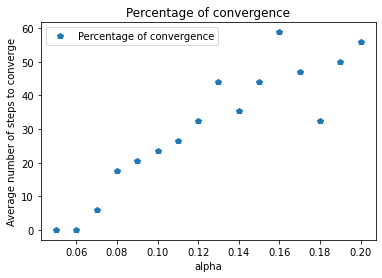

In [ ]:
import matplotlib.pyplot as plt

file="AmpG_8.txt"

f = open(file, "r")
S=f.read()
f.close()

S1=S.split(";")
S_alpha=S1[0].split(",")
S_conv=S1[1].split(",")
S_essais=S1[2].split(",")
S_steps=S1[3].split(",")
    
L_alpha=[float(x) for x in S_alpha]
L_conv=[float(x) for x in S_conv]
L_essais=[float(x) for x in S_essais]
L_steps=[float(x) for x in S_steps]

print(L_conv)
print(L_essais)


plt.xlabel('alpha')
#plt.xscale("log")
plt.ylabel('Average number of steps to converge')
plt.plot(L_alpha,100*np.array(L_conv)/np.array(L_essais),'p', label="Percentage of convergence")
plt.title('Percentage of convergence')
plt.legend()
plt.show()

<ipython-input-5-580ff876bd96>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(L_alpha,(np.array(L_steps)-(np.array(L_essais)-np.array(L_conv))*8000)/np.array(L_conv),"p", label="Average number of steps to converge")


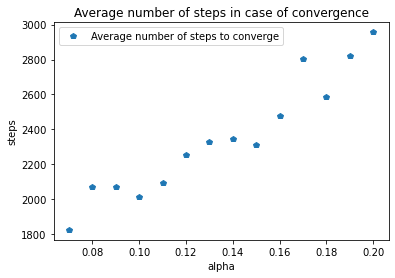

In [ ]:


plt.xlabel('alpha')
#plt.xscale("log")
plt.ylabel('steps')
plt.plot(L_alpha,(np.array(L_steps)-(np.array(L_essais)-np.array(L_conv))*8000)/np.array(L_conv),"p", label="Average number of steps to converge")
plt.title('Average number of steps in case of convergence')
plt.legend()
plt.show()

<ipython-input-6-e64bc78c8813>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(L_alpha,np.array(L_steps)/np.array(L_conv),"p")
No handles with labels found to put in legend.


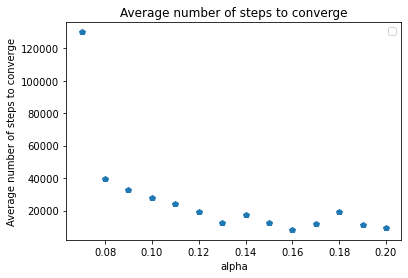

In [ ]:


plt.xlabel('alpha')
#plt.xscale("log")
plt.ylabel('Average number of steps to converge')
plt.plot(L_alpha,np.array(L_steps)/np.array(L_conv),"p")
plt.title('Average number of steps to converge')
plt.legend()
plt.show()

In [ ]:
def resetF(file):
    f = open(file, "w")
    # f = L_alpha, L_conv, L_essais
    A=np.linspace(0.05,0.2,16)
    N=len(A)
    S=""
    for a in A:
        S+=str(a)+","
    S=S[:-1]
    S+=";"
    for i in range(N):
        S+="0,"
    S=S[:-1]
    S+=";"
    for i in range(N):
        S+="0,"
    S=S[:-1]
    S+=";"
    for i in range(N):
        S+="0,"
    S=S[:-1]
    f.write(S)
    
    f = open(file, "r")
    print(f.read())
    print("done")

#"AmpG_2.txt"

In [ ]:
resetF("AmpG_9.txt")

0.05,0.060000000000000005,0.07,0.08000000000000002,0.09000000000000001,0.1,0.11000000000000001,0.12000000000000001,0.13,0.14,0.15000000000000002,0.16000000000000003,0.17000000000000004,0.18000000000000005,0.19,0.2;0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0;0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0;0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
done


In [ ]:
f = open("AmpG_1.txt", "r")
print(f.read())
f.close()

0.01,0.012742749857031334,0.016237767391887217,0.0206913808111479,0.026366508987303583,0.03359818286283781,0.04281332398719394,0.0545559478116852,0.06951927961775606,0.08858667904100823,0.11288378916846889,0.14384498882876628,0.18329807108324356,0.23357214690901212,0.29763514416313175,0.37926901907322497,0.4832930238571752,0.615848211066026,0.7847599703514611,1.0;0.0,0.0,0.0,0.0,0.0,0.0,11.0,15.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0;15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0


In [ ]:
f = open("AmpG_5.txt", "r")
print(f.read())
f.close()

0.06,0.06379310344827586,0.06758620689655172,0.07137931034482758,0.07517241379310345,0.07896551724137932,0.08275862068965517,0.08655172413793104,0.0903448275862069,0.09413793103448276,0.09793103448275862,0.10172413793103449,0.10551724137931034,0.10931034482758621,0.11310344827586208,0.11689655172413793,0.1206896551724138,0.12448275862068967,0.12827586206896552,0.1320689655172414,0.13586206896551725,0.1396551724137931,0.14344827586206899,0.14724137931034484,0.1510344827586207,0.15482758620689657,0.15862068965517243,0.16241379310344828,0.16620689655172416,0.17;10.0,10.0,10.0,10.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0;10.0,10.0,10.0,10.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0;9659.0,6963.0,7213.0,7152.0,7179.0,5076.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def read(file):
    f = open(file, "r")
    S=f.read()
    f.close()
    
    S1=S.split(";")
    S_alpha=S1[0].split(",")
    S_conv=S1[1].split(",")
    S_essais=S1[2].split(",")
    
    L_alpha=[float(x) for x in S_alpha]
    L_conv=[float(x) for x in S_conv]
    L_essais=[float(x) for x in S_essais]

    print(f"\nAlpha: {L_alpha}\nConvergences: {L_conv}\nEssais: {L_essais}\n")

In [ ]:
def tikz():
    f = open("AmpG_8.txt", "r")
    S=f.read()
    f.close()
    
    S1=S.split(";")
    S_alpha=S1[0].split(",")
    S_conv=S1[1].split(",")
    S_essais=S1[2].split(",")
    S_steps=S1[3].split(",")

    L_alpha=[float(x) for x in S_alpha]
    L_conv=[float(x) for x in S_conv]
    L_essais=[float(x) for x in S_essais]
    L_steps=[float(x) for x in S_steps]
    
    X=np.array(L_alpha)
    ind_conv=[i for i in range(len(X)) if L_conv[i]!=0]
    X_conv=X[ind_conv]
    
    Lc_steps, Lc_conv, Lc_essais=[L_steps[j] for j in ind_conv], [L_conv[j] for j in ind_conv], [L_essais[j] for j in ind_conv]
    Y1=100*np.array(L_conv)/np.array(L_essais) # P
    Y2=np.array(Lc_steps)/np.array(Lc_conv) #Step_tot_tot
    Y3=(np.array(Lc_steps)-(np.array(Lc_essais)-np.array(Lc_conv))*8000)/np.array(Lc_conv)
    
    S1, S2, S3= "", "", ""
    n=len(X)
    nc=len(X_conv)
    for i in range(n):
        S1+=str(X[i])+"\t"+str(Y1[i])+"\n"
    for i in range(nc):
        S2+=str(X_conv[i])+"\t"+str(Y2[i])+"\n"
        S3+=str(X_conv[i])+"\t"+str(Y3[i])+"\n"
        
    f1 = open("Y1.txt", "w")
    f1.write(S1)
    f1.close()
    
    f1 = open("Y2.txt", "w")
    f1.write(S2)
    f1.close()
    
    f1 = open("Y3.txt", "w")
    f1.write(S3)
    f1.close()
    
tikz()
    